In [1]:
from __future__ import print_function, division
import os
import torch
from torch.optim.optimizer import Optimizer
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from skimage import io
import torch.nn as nn
import torch.nn.functional as F

from skimage.color import rgb2gray

from torch.utils.tensorboard import SummaryWriter

import PIL
from PIL import Image

from google.colab import output

In [2]:
%mkdir results

In [3]:
!git clone https://github.com/PauliusMilmantas/Bakalaurinis_darbas

Cloning into 'Bakalaurinis_darbas'...
remote: Enumerating objects: 137, done.
remote: Counting objects: 100% (137/137), done.
remote: Compressing objects: 100% (100/100), done.
remote: Total 137 (delta 56), reused 116 (delta 35), pack-reused 0
Receiving objects: 100% (137/137), 1.80 MiB | 5.43 MiB/s, done.
Resolving deltas: 100% (56/56), done.


In [4]:
%cd /content/Bakalaurinis_darbas/Code

/content/Bakalaurinis_darbas/Code


In [5]:
def get_answer(output):
  if output[0] > output[1]:
    return 0
  else:
    return 1

In [6]:
import pandas as pd

class ORCDataset(Dataset):
  def __init__(self, root):
    self.root = root
    self.data = pd.read_csv(root)

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    dat = {}
    dat['Pregnancies'] = self.data['Pregnancies'][idx]
    dat['Glucose'] = self.data['Glucose'][idx]
    dat['BloodPressure'] = self.data['BloodPressure'][idx]
    dat['BMI'] = self.data['BMI'][idx]
    dat['Age'] = self.data['Age'][idx]
    found_type = self.data['Outcome'][idx]

    return {'data': dat, 'class_name': found_type}

train_dataset = ORCDataset('/content/Bakalaurinis_darbas/Code/train.csv')
test_dataset = ORCDataset('/content/Bakalaurinis_darbas/Code/test.csv')

In [7]:
class Net(nn.Module):
    def __init__(self, input_size, hidden1_size, hidden2_size, num_classes):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden1_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden1_size, hidden2_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden2_size, num_classes)  
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)        
        out = self.relu2(out)     
        out = self.fc3(out)
        return out

2 <- 7 <- 15 <- 5

In [8]:
network = Net(5, 15, 7, 2)
optimizer = torch.optim.SGD(network.parameters(), lr=0.0001, momentum=0.6)
criterion = nn.MSELoss().cuda()

print(network)

Net(
  (fc1): Linear(in_features=5, out_features=15, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=15, out_features=7, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=7, out_features=2, bias=True)
)


In [9]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
network.to(dev)
criterion.to(dev)
dev

device(type='cpu')

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

Using device: cpu



In [11]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = len(train_dataset),shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = len(test_dataset),shuffle=True)

In [12]:
dataiter = iter(train_loader)
itr = dataiter.next()

label = itr['class_name']
dat = itr['data']
print("Class name: {} Data: [Pregnancies: {} Glucose: {} BloodPressure: {} BMI: {} Age: {}]".format(label[0], dat['Pregnancies'][0], dat['Glucose'][0], dat['BloodPressure'][0], dat['BMI'][0], dat['Age'][0]))

Class name: 0 Data: [Pregnancies: 5 Glucose: 114 BloodPressure: 74 BMI: 24.9 Age: 57]


Epoch: 0 Training loss: 321.93927558814175 Accuracy: 64.49704142011834
Epoch: 1 Training loss: 202.8902275358996 Accuracy: 63.905325443786985
Epoch: 2 Training loss: 185.5209742009174 Accuracy: 63.905325443786985
Epoch: 3 Training loss: 170.18973704369273 Accuracy: 39.64497041420118
Epoch: 4 Training loss: 169.7053333830554 Accuracy: 63.905325443786985
Epoch: 5 Training loss: 163.44630118482746 Accuracy: 65.08875739644971
Epoch: 6 Training loss: 157.61601634230465 Accuracy: 66.86390532544378
Epoch: 7 Training loss: 156.96602679241914 Accuracy: 63.905325443786985
Epoch: 8 Training loss: 154.61634092684835 Accuracy: 68.63905325443787
Epoch: 9 Training loss: 152.74354718226823 Accuracy: 66.27218934911244
Epoch: 10 Training loss: 150.452846680535 Accuracy: 69.8224852071006
Epoch: 11 Training loss: 149.0799198068853 Accuracy: 63.905325443786985
Epoch: 12 Training loss: 147.79318115935894 Accuracy: 66.86390532544378
Epoch: 13 Training loss: 142.88203734951094 Accuracy: 65.08875739644971
Epoc

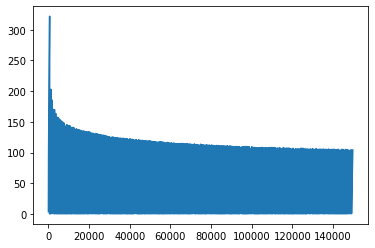

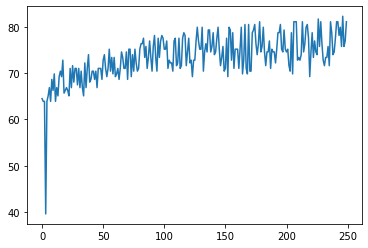

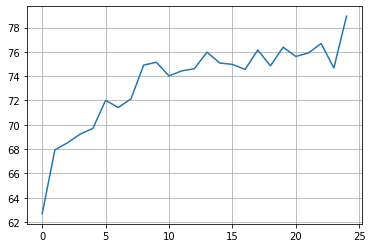

In [13]:
def train(train_loader, test_loader, epoch_amount, save_checkpoint = 10):
  network.eval()
  train_loss_hist = []
  acc_history = []

  checkpoint = save_checkpoint
  for epoch in range(epoch_amount):
    num_data_train = 0

    # TRAINING DATASET
    correct = 0
    wrong = 0
    for data in train_loader:
      labels = torch.from_numpy(np.array(data['class_name']))
      dat = data['data']

      lossSum = 0

      parsedData = []
      for dictIdx in range(len(labels)):
        parsedData.append(
            np.array([dat['Pregnancies'][dictIdx].float(), dat['Glucose'][dictIdx].float(), dat['BloodPressure'][dictIdx].float(), dat['BMI'][dictIdx].float(), dat['Age'][dictIdx].float()])
            )

      for idx in range(len(labels)):
        optimizer.zero_grad()

        outputs = network(torch.Tensor(parsedData[idx].flatten()))
        realAnswer = [0, 0]
        realAnswer[labels[idx]] = 1

        loss = criterion(outputs, torch.Tensor(realAnswer))
          
        loss.backward()

        lossSum += loss.item()
        train_loss_hist.append(lossSum)

        optimizer.step()

    # TESTING DATASET
    for data in test_loader:
      labels = torch.from_numpy(np.array(data['class_name']))
      dat = data['data']

      parsedData = []
      for dictIdx in range(len(labels)):
        parsedData.append(
            np.array([dat['Pregnancies'][dictIdx].float(), dat['Glucose'][dictIdx].float(), dat['BloodPressure'][dictIdx].float(), dat['BMI'][dictIdx].float(), dat['Age'][dictIdx].float()])
            )

      for idx in range(len(labels)):
        outputs = network(torch.Tensor(parsedData[idx].flatten()))

        predicted = get_answer(outputs)
        real_answer = labels[idx].item()

        if predicted == real_answer:
          correct += 1
        else:
          wrong += 1

    acc_history.append(
        correct/(correct+wrong)*100
    )
    print("Epoch: {} Training loss: {} Accuracy: {}".format(epoch,train_loss_hist[len(train_loss_hist) - 1], acc_history[len(acc_history) - 1]))
    
    if(checkpoint == 0):
      torch.save(network.state_dict(), '/content/results/model.pth')
      torch.save(optimizer.state_dict(), '/content/results/optimizer.pth')

      checkpoint = save_checkpoint
    else:
      checkpoint -= 1

  plt.plot(np.arange(0, len(train_loss_hist), 1), train_loss_hist)
  plt.show()

  plt.plot(np.arange(0, len(acc_history), 1), acc_history)
  plt.show()

  avg_hist = []

  for i in range(int(len(acc_history)/10)):
    avg = 0
    
    for p in range(10):
      avg += acc_history[i*10 + p]

    avg_hist.append(avg/10)

  plt.plot(np.arange(0, len(avg_hist)), avg_hist)
  plt.grid()
  plt.show()

train(train_loader, test_loader, 250)


Palieka tik tie duomenys iš training_set, kurie yra teisingai atsakyti

In [14]:
increaseValues = [0, 0, 0, 0, 0]
dataIdx = [0, 0, 0, 0, 0]

for data in train_loader:
      labels = torch.from_numpy(np.array(data['class_name']))
      dat = data['data']

      parsedData = []
      for dictIdx in range(len(labels)):
        parsedData.append(
            np.array([dat['Pregnancies'][dictIdx].float(), dat['Glucose'][dictIdx].float(), dat['BloodPressure'][dictIdx].float(), dat['BMI'][dictIdx].float(), dat['Age'][dictIdx].float()])
            )

      for idx in range(len(labels)):
        outputs = network(torch.Tensor(parsedData[idx].flatten()))
        
        predicted = get_answer(outputs)
        real_answer = labels[idx].item()

        collumnIdx = 0
        for collumnIdx in range(5):

          # Sutampa duomenys, vykdoma tolimesne analize
          if(predicted == real_answer):
            epsilon = 0.1
            increase = 0
            dataIdx[collumnIdx] += 1

            while(predicted == real_answer and increase < 100):
              tempData = parsedData[idx].flatten()
              increase += epsilon
              tempData[0] += increase

              outputs = network(torch.Tensor(tempData))

              predicted = get_answer(outputs)
              real_answer = labels[idx].item()

            increaseValues[collumnIdx] += increase

for i in range(5):
  if dataIdx[i] == 0:
    dataIdx[i] = 1

  print("{}th collumn maximum epsilon: {}".format(i, increaseValues[i]/dataIdx[i]))

s = 0
for i in range(5):
  s += increaseValues[i]/dataIdx[i]

print("Model maximum epsilon: {}".format(s/5))

0th collumn maximum epsilon: 36.69711751662934
1th collumn maximum epsilon: 100.09999999999856
2th collumn maximum epsilon: 100.09999999999856
3th collumn maximum epsilon: 100.09999999999856
4th collumn maximum epsilon: 100.09999999999856
Model maximum epsilon: 87.41942350332471
